Reproduce: SimPEG
====================

## Simulating Gravity Anomaly Data Over a Block in a Halfspace

Gravity anomaly data are simulated for a density contrast model over block in a halfspace. The density contrast of the background is 0 $g/cm^3$ and the density contrast of the block is 0.1 $g/cm^3$. The dimensions of the block in the x, y and z directions are all 200 m. The block is buried at a depth of 200 m.

Gravity anomaly data are simulated on a regular grid of points at a heigh of 1 m above the Earth's surface. The station spacing is 50 m in both the X and Y directions.

## SimPEG Package Details

**Link to the docstrings for the simulation class.** The docstrings will have a citation and show the integral equation.

## Running the Forward Simulation

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
from SimPEG import dask
from SimPEG.potential_fields import gravity
from SimPEG.utils import plot2Ddata
from SimPEG.utils.io_utils import read_grav3d_ubc, write_grav3d_ubc
from SimPEG import maps, data
from discretize import TensorMesh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update({"font.size": 14})
write_output = True

A compressed folder containing the assets required to run the notebook is then downloaded. This includes mesh, model and survey files for the forward simulation.

In [2]:
# Download .tar files

Extracted files are then loaded into the SimPEG framework.

In [3]:
rootdir = './../../../assets/gravity/block_halfspace_gravity_fwd_simpeg/'
meshfile = rootdir + 'mesh.txt'
modelfile = rootdir + 'model.den'
locfile = rootdir + 'survey.loc'

mesh = TensorMesh.read_UBC(meshfile)
model = TensorMesh.read_model_UBC(mesh, modelfile)
grav_data = read_grav3d_ubc(locfile)

Below, we plot the model and the survey geometry used in the forward simulation.

Text(0, 0.5, 'y (m)')

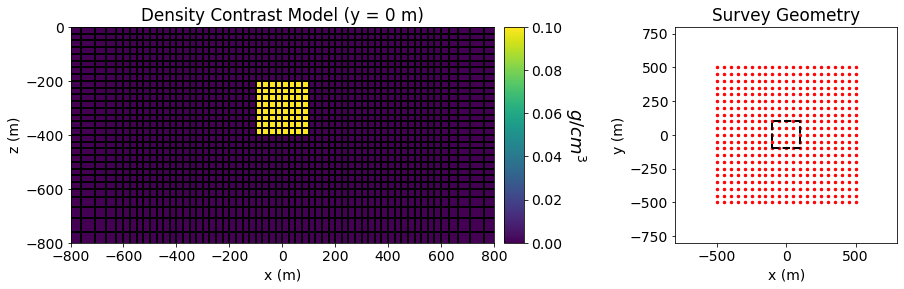

In [4]:
fig = plt.figure(figsize=(14, 4))

ax11 = fig.add_axes([0.1, 0.15, 0.42, 0.75])
ind = int(mesh.shape_cells[1]/2)
mesh.plot_slice(
    model, normal='Y', ind=ind, grid=True, ax=ax11, pcolor_opts={"cmap": "viridis"}
)

ax11.set_xlim([-800, 800])
ax11.set_ylim([-800, 0])
ax11.set_title("Density Contrast Model (y = 0 m)")
ax11.set_xlabel("x (m)")
ax11.set_ylabel("z (m)")

ax12 = fig.add_axes([0.53, 0.15, 0.02, 0.75])
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax12, norm=norm, cmap=mpl.cm.viridis, orientation="vertical"
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=25, size=18)

xyz = grav_data.survey.receiver_locations
ax21 = fig.add_axes([0.7, 0.15, 0.22, 0.75])
ax21.scatter(xyz[:, 0], xyz[:, 1], 6, 'r')
ax21.plot(100*np.r_[-1, 1, 1, -1, -1], 100*np.r_[-1, -1, 1, 1, -1], 'k--', lw=2)
ax21.set_xlim([-800, 800])
ax21.set_ylim([-800, 800])
ax21.set_title("Survey Geometry")
ax21.set_xlabel("x (m)")
ax21.set_ylabel("y (m)")

Here we define the mapping from the model to the mesh, extract the survey from the data object and define the forward simulation.

In [5]:
rho_map = maps.IdentityMap(nP=mesh.nC)

survey = grav_data.survey

simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=rho_map,
    store_sensitivities="forward_only"
)

Finally, we predict the TMI data for the model provided.

In [6]:
dpred_simpeg = simulation.dpred(model)

Forward calculation: 
[########################################] | 100% Completed |  2min 33.3s


If desired, we can export the simulated gravity data to a UBC formatted data file.

In [7]:
if write_output:
    data_simpeg = data.Data(survey=survey, dobs=dpred_simpeg)
    outname = rootdir + 'dpred_simpeg.grv'
    write_grav3d_ubc(outname, data_simpeg)

Observation file saved to: ./../../../assets/gravity/block_halfspace_gravity_fwd_simpeg/dpred_simpeg.grv


## Simulated Gravity Data Plot

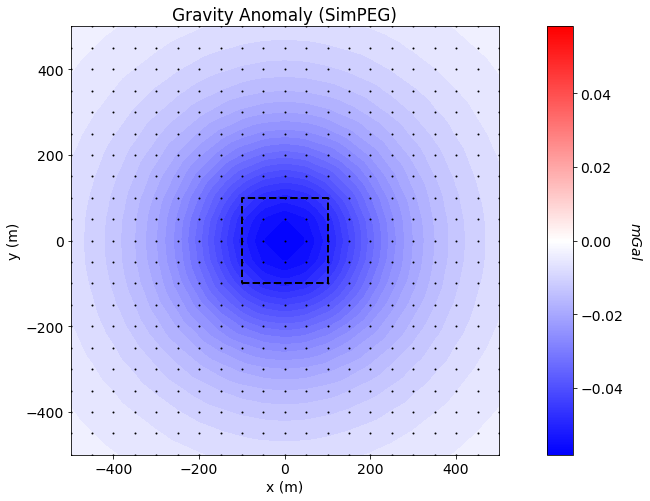

In [8]:
xyz = survey.receiver_locations
max_val = np.max(np.abs(dpred_simpeg))

fig = plt.figure(figsize=(9, 7))

ax1 = fig.add_axes([0.05, 0.1, 0.85, 0.85])
plot2Ddata(
    xyz, dpred_simpeg, ax=ax1, clim=(-max_val, max_val),
    dataloc=True, ncontour=50, contourOpts={"cmap": "bwr"}
)
ax1.plot(100*np.r_[-1, 1, 1, -1, -1], 100*np.r_[-1, -1, 1, 1, -1], 'k--', lw=2.)
ax1.set_title("Gravity Anomaly (SimPEG)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.88, 0.1, 0.04, 0.85])
norm = mpl.colors.Normalize(vmin=-max_val, vmax=max_val)
cbar2 = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar2.set_label("$mGal$", rotation=270, labelpad=20, size=14)

plt.show()